# Kaggle GI Tract Inference

Using code snippets from:
https://www.kaggle.com/code/yiheng/3d-solution-with-monai-produce-3d-data/notebook
https://www.kaggle.com/code/israrahmed919/createmasksopencv
https://www.kaggle.com/code/clemchris/gi-seg-pytorch-train-infer




**Notes**
* 


In [1]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from einops import rearrange, reduce, repeat
import segmentation_models_pytorch as smp
from tqdm import tqdm




ROOT_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/'
MODEL_FOLDER = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models'

model_file_base = 'Unet-1-1.pth'
n_folds = 5

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#DEVICE = "cpu"
#DEVICE = "cuda:0"

# Data

## Process the Test files

#### Set the debug mode
`debug = True` will result in using all the training images to do inference and also do a check on the resize+ pad transform needed to invert the basic training transform  (crop+resize)


`debug = False` will result in using the test images

In [2]:
debug = True

In [3]:
if debug:  # Use the training files as input
    test_fnames = glob.glob("{}train/*/*/scans/*.png".format(ROOT_FOLDER))
else:  # Use the test files as input
    test_fnames = glob.glob("{}test/*/*/scans/*.png".format(ROOT_FOLDER))

### Get the filenames for the test files and make a dataframe for inference



In [4]:

file_df = pd.DataFrame(test_fnames)

In [5]:
file_df.columns = ["path"]

We need to submit a csv with the following columns

In [9]:
sub_df = pd.read_csv(ROOT_FOLDER+'/sample_submission.csv')

In [10]:
sub_df.columns

Index(['id', 'class', 'predicted'], dtype='object')

We need a way to get the `id` for the submission from the file paths

Build a function that does the string manipulation

In [6]:
def id_from_path(p):
    
    #p = '/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train/case24/case24_day25/scans/slice_0046_266_266_1.50_1.50.png'
    s1 = p.split('/')
    filename = s1[-1] # 'slice_0046_266_266_1.50_1.50.png'
    case_day_str = s1[-3] # 'case24_day25'
    slice_str = '_'.join(filename.split('_')[-7:-4]) #'slice_0046'
    id_str = case_day_str + '_' + slice_str #'case24_day25_slice_0046'
    return id_str
    
    

In [7]:
file_df["id"] = file_df["path"].apply(id_from_path)

In [8]:
file_df

,path,id
0,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0046
1,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0099
2,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0013
3,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0064
4,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case24_day25_slice_0090
...,...,...
38491,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0049
38492,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0079
38493,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0093
38494,/media/SSD/gi-tract/uw-madison-gi-tract-image-...,case29_day0_slice_0119


## Get the NN Models

For each fold of the data we have a model, so we need to get all of them.  They are not huge so we can keep all of them in the GPU.

In [11]:
models = []
for fold in range(0,n_folds):
    
    model = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3)                    # model output channels (number of classes in your dataset)
    
    model_in_str = MODEL_FOLDER+ "/" + "fold-" + str(fold) + '-' + model_file_base 
    print(model_in_str)
    model.load_state_dict(torch.load(model_in_str))
    model.to(torch.device(DEVICE))
    model.eval()
    models.append(model)
    

/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-0-Unet-1-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-1-Unet-1-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-2-Unet-1-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-3-Unet-1-1.pth
/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/kaggle models/fold-4-Unet-1-1.pth


## Create a Pytorch Dataset for inference

The main difference relative to training is we don't have the ground truth run length encoded mask.
We also provide the `id` used in the submission because its the key

In [12]:
from torchvision.transforms import PILToTensor

In [13]:
class Dataset_from_df_inference(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.pil_to_tensor = PILToTensor()

        
    def __len__(self):
        return self.df.shape[0]
        
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        
        img_path = row.path
        # Use PIL Image to read the image files since it handles 32 bit images
        img = self.pil_to_tensor(Image.open(img_path))
        #print(img.shape)
        
        
        
        # capture the shape of the original image because we want our final mask
        # used for RLE to match this shape
        mask_shape = img.shape

        
        
        # resize our image to a consistent size to provide as input to model
        if self.transform:
            img = self.transform(img)
    
        
        
        return {
            "image": img,
            "mask_shape": mask_shape,
            "id": row.id #return the row id used in the submission
        }
        
        
    
    


### Define our transform
We use the basic imaging sizing from Training because that recreates the conditions under which we trained

In [14]:
from torchvision import transforms
from torch.nn import functional as F

In [15]:
test_transforms = transforms.Compose(
    [transforms.CenterCrop((266,266)),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Resize((288,288),interpolation=transforms.InterpolationMode.BICUBIC)])  # multiple of 32 for UUnet

### Create the Dataset
And ensure it returns what we expect

In [16]:
test_dataset = Dataset_from_df_inference(file_df,test_transforms)

In [17]:
test_dataset[0]['mask_shape'], test_dataset[0]['id']

(torch.Size([1, 266, 266]), 'case24_day25_slice_0046')

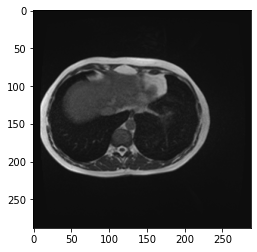

In [18]:
plt.imshow(test_dataset[0]['image'].squeeze().numpy(),cmap='gray')

## Inference Processing

Create the dataloader. Kaggle reccommends `num_workers=2` when using the GPU.  We may have to change the `batch_size` and `pin_memory` settings for Kaggle virtual machine.

In [19]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=16,
                                               num_workers=2,
                                               pin_memory=True, #pagelock the memory for faster loads to GPU RAM
                                               shuffle=False)

In [20]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Threshold for turning the masking image prediction into an image with pixels of 0 or 1 per channel
Reflects how high we need the predicted probababilty before we count the pixel in the mask
Also the image resizing impacts the mask edges (we use bicubic interpolation to avoid some of this) so a lower threshold might be needed to have the masks with pixels of 0 or 1 register edges better.

Should be between 0 and 1.0, on the higher side.

In [21]:

threshold = .8

Loop through our test data and create the submission

In [28]:
sub = {'id':[], 'class':[], 'predicted':[]} # a dict to store our submission
pbar = tqdm(total=len(test_dataloader))


for batch in test_dataloader:
    
    images = batch['image'].to(DEVICE)
    mask_shape = batch['mask_shape']
    ids = batch['id']
    

    #Take each of our fold models and average the outputs together
    with torch.no_grad():
        output = models[0](images)
        output = torch.nn.Sigmoid()(output)/n_folds
        mask = output
        for i in range(1,n_folds):
            output = models[i](images)
            output = torch.nn.Sigmoid()(output)/n_folds
            mask = mask + output
    
    #print("1", mask.shape)


    #From here we need to apply the invert of the the basic image crop and resize exactly to the mask image
    #and then apply run length encoding to that image
    
    mask = transforms.Resize((266,266),interpolation=transforms.InterpolationMode.BICUBIC)(mask) # undo resize to 288x288
    #print("3", mask.shape)
    
    #print(4,mask_shape)
    
    a0 = torch.div(mask_shape[1] - 266,2,rounding_mode = 'floor') # (mask_shape[1] - 266)//2
    a1 = torch.div(mask_shape[2] - 266,2,rounding_mode = 'floor')
    #print(a0,a1)
    
    # Since we are processing a batch, the final mask shape may change within a batch
    # So we can't store that as a 1 tensor per batch
    # Need to process each batch item individually from here

    #single_mask = torch.zeros_like(mask[0])
    batch_size = mask.shape[0]  # need to get for each batch since last batch may smaller
    for b in range(0,batch_size):
        single_mask = F.pad(mask[b],(a1[b], a1[b], a0[b], a0[b]),  "constant", 0) #padding param order confirmed
        #print("5", single_mask.shape)
        
        if debug:  #confirm the mask image inverse returns the same size as orig mask image
            if (single_mask.shape[1] != mask_shape[1][b]) or (single_mask.shape[2] != mask_shape[2][b]):
                print("mask in:",mask[b].shape)
                print("mismatch:",mask_shape[1][b],mask_shape[2][b], single_mask.shape)
            
            
        single_mask = (single_mask > threshold)*1.0  # Run Length encoding requires a mask with 0 or 1
        single_mask = single_mask.cpu().detach().numpy() # go from a tensor on the GPU to a numpy on CPU

        # create 3 submission rows, one for each organ
        sub_id = ids[b] #get the submission id from the batch
        
        large_bowel = rle_encode(single_mask[0])
        sub['id'].append(sub_id)
        sub['class'].append('large_bowel')
        sub['predicted'].append(large_bowel)

        small_bowel = rle_encode(single_mask[1])
        sub['id'].append(sub_id)
        sub['class'].append('small_bowel')
        sub['predicted'].append(small_bowel)

        stomach = rle_encode(single_mask[2])
        sub['id'].append(sub_id)
        sub['class'].append('stomach')
        sub['predicted'].append(stomach)    

    

        
   
    pbar.update(1)
    #break
pbar.close()
torch.cuda.empty_cache()


100%|███████████████████████████████████████| 2406/2406 [10:58<00:00,  3.66it/s]


### Create submission file

In [23]:
sub_df = pd.DataFrame(sub)

In [24]:
# replace NaNs with an empty string for the 'predicted' column
sub_df.predicted = sub_df.predicted.fillna('')

In [25]:
sub_df

,id,class,predicted
0,"[case24_day25_slice_0046, case24_day25_slice_0...",large_bowel,
1,"[case24_day25_slice_0046, case24_day25_slice_0...",small_bowel,
2,"[case24_day25_slice_0046, case24_day25_slice_0...",stomach,
3,"[case24_day25_slice_0046, case24_day25_slice_0...",large_bowel,21375 11 21395 2 21638 39 21903 44 22168 48 22...
4,"[case24_day25_slice_0046, case24_day25_slice_0...",small_bowel,22759 4 23025 7 23291 9 23557 10 23823 11 2408...
...,...,...,...
115483,"[case29_day0_slice_0106, case29_day0_slice_009...",small_bowel,18489 3 18753 8 18996 12 19018 1 19027 2 19255...
115484,"[case29_day0_slice_0106, case29_day0_slice_009...",stomach,
115485,"[case29_day0_slice_0106, case29_day0_slice_009...",large_bowel,
115486,"[case29_day0_slice_0106, case29_day0_slice_009...",small_bowel,


In [26]:
ROOT_FOLDER + 'train_sub_gpu2.csv'

'/media/SSD/gi-tract/uw-madison-gi-tract-image-segmentation/train_sub_gpu2.csv'

In [27]:
sub_df.to_csv(ROOT_FOLDER + 'train_sub_gpu2.csv', index = False)